In [19]:
from PyHessian.pyhessian.hessian import hessian
from PyHessian.density_plot import get_esd_plot
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms
# from keras.datasets import mnist
import matplotlib.pyplot as plt 
import time

# PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
# How to do this?
import os

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'



In [20]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [21]:
mnist_trainset = datasets.MNIST(root='./data/mnist', train=True, download=True, transform=transforms.ToTensor())
mnist_fashion_trainset = datasets.FashionMNIST(root='./data/fashion_mnist', train=True, download=True, transform=transforms.ToTensor())
cifar_trainset = datasets.CIFAR10(root='./data/cifar10', train=True, download=True, transform=transforms.ToTensor())
# Getting mnist test data
mnist_testset = datasets.MNIST(root='./data/mnist', train=False, download=True, transform=transforms.ToTensor())
mnist_fashion_testset = datasets.FashionMNIST(root='./data/fashion_mnist', train=False, download=True, transform=transforms.ToTensor())
cifar_testset = datasets.CIFAR10(root='./data/cifar10', train=False, download=True, transform=transforms.ToTensor())

torch.manual_seed(42)

Files already downloaded and verified
Files already downloaded and verified


In [22]:
train_X = cifar_trainset.data
train_y = cifar_trainset.targets
test_X = cifar_testset.data
test_y = cifar_testset.targets

In [23]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Using conv layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*8*8, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [24]:
# Reading train images as c w h instead of w h c
train_X = torch.tensor(train_X).permute(0, 3, 1, 2)
test_X = torch.tensor(test_X).permute(0, 3, 1, 2)


train_X = (torch.tensor(train_X, dtype=torch.float32)/255).to(device)
test_X = (torch.tensor(test_X, dtype=torch.float32)/255).to(device)
train_y = (torch.tensor(train_y, dtype=torch.int64)).to(device)
test_y = (torch.tensor(test_y, dtype=torch.int64)).to(device)



/tmp/ipykernel_13323/1053739760.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_X = (torch.tensor(train_X, dtype=torch.float32)/255).to(device)
/tmp/ipykernel_13323/1053739760.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_X = (torch.tensor(test_X, dtype=torch.float32)/255).to(device)


In [25]:
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_X, train_y),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(test_X, test_y),
    batch_size=64, shuffle=False)

model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [26]:
# losses = []
# test_losses = []
# train_losses = []
# for epoch in range(10):
#     for i, (data, target) in enumerate(dataloader):
#         optimizer.zero_grad()
#         output = model(data)
#         #output_test = model(test_X)
#         loss = criterion(output, target)
#         # loss_test = criterion(output_test, test_y)
#         loss.backward()
#         optimizer.step()
#         losses.append(loss.item())
#         if i % 100 == 0:
#             print(f"Epoch {epoch}, step {i}, train_loss {loss.item()}")
#         # output = model(train_X)
#         # loss_train = criterion(output, train_y)
#         # output = model(test_X)
#         # loss_test = criterion(output, test_y)
#         # output_test = model(test_X)
#         # test_losses.append(loss_test.item())
#         # train_losses.append(loss_train.item())
#     #print(loss.item())

In [27]:
losses = []
test_losses = []
train_losses = []
for epoch in range(10):
    for i, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        #output_test = model(test_X)
        loss = criterion(output, target)
        # loss_test = criterion(output_test, test_y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if i % 500 == 0:
            # output = model(train_X)
            # loss_train = criterion(output, train_y)
            # output = model(test_X)
            # loss_test = criterion(output, test_y)
            # print(f"Epoch {epoch}, step {i}, train_loss {loss.item()}, test_loss {loss_test.item()}")
            print(f"Epoch {epoch}, step {i}, train_loss {loss.item()}")
            # test_losses.append(loss_test.item())
            # train_losses.append(loss_train.item())
    with torch.no_grad():
        output = model(train_X)
        loss_train = criterion(output, train_y)
        output = model(test_X)
        loss_test = criterion(output, test_y)
        print(f"Epoch {epoch}, train_loss {loss_train.item()}, test_loss {loss_test.item()}")
        test_losses.append(loss_test.item())
        train_losses.append(loss_train.item())

Epoch 0, step 0, train_loss 2.3034801483154297


Epoch 0, step 500, train_loss 1.4623819589614868
Epoch 0, train_loss 1.2032445669174194, test_loss 1.2304691076278687
Epoch 1, step 0, train_loss 1.2054295539855957
Epoch 1, step 500, train_loss 1.2305055856704712
Epoch 1, train_loss 0.9418049454689026, test_loss 1.0168232917785645
Epoch 2, step 0, train_loss 0.985579788684845
Epoch 2, step 500, train_loss 0.9313868284225464
Epoch 2, train_loss 0.7742645144462585, test_loss 0.9067519307136536
Epoch 3, step 0, train_loss 1.0034397840499878
Epoch 3, step 500, train_loss 0.8455233573913574
Epoch 3, train_loss 0.6797326803207397, test_loss 0.8705582022666931
Epoch 4, step 0, train_loss 0.8424872756004333
Epoch 4, step 500, train_loss 0.6176832318305969
Epoch 4, train_loss 0.6300923228263855, test_loss 0.8862622976303101
Epoch 5, step 0, train_loss 0.6512939929962158
Epoch 5, step 500, train_loss 0.700094997882843
Epoch 5, train_loss 0.529354453086853, test_loss 0.837205171585083
Epoch 6, step 0, train_loss 0.45212480425834656
Epoch 6, step

In [28]:
# Calculate test accuracy
model.eval()
output = model(test_X)
_, predicted = torch.max(output, 1)
correct = (predicted == test_y).sum().item()
accuracy = correct / test_y.size(0)
print(f"Test accuracy: {accuracy}")

Test accuracy: 0.7499


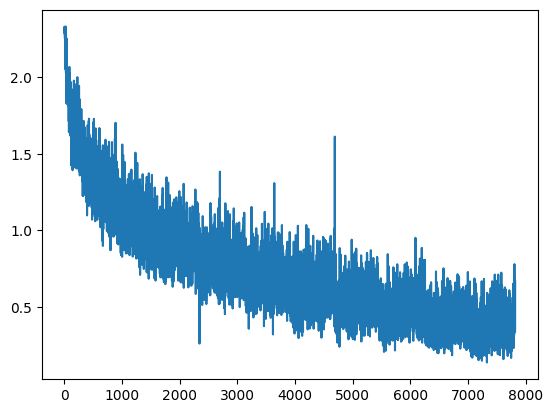

In [29]:
%matplotlib inline
plt.plot(losses)
plt.show()

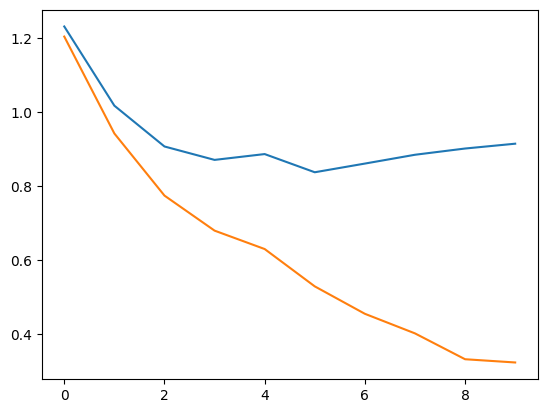

In [30]:
plt.plot(test_losses)
plt.plot(train_losses)
plt.show()

In [31]:
# print(torch.cuda.memory_summary(device=None, abbreviated=False))
# import gc
# for obj in gc.get_objects():
#     if torch.is_tensor(obj):
#         if obj.is_cuda:
#             print(f'Tensor: {obj}, Size: {obj.size()}, Memory: {obj.element_size() * obj.nelement() / 1024**2:.2f} MB')


In [32]:
# loader = []
# for i, (data, target) in enumerate(dataloader):
#     loader.append((data, target))

# loader = torch.utils.data.DataLoader(
#     torch.utils.data.TensorDataset(train_X, train_y),
#     batch_size=1024, shuffle=True)
num_batches = 10
loader = []
for i, (data, target) in enumerate(train_loader):
    if i == num_batches:
        break
    loader.append((data, target))
    

In [33]:
model.eval()
model = nn.DataParallel(model)
hessian_comp = hessian(model, criterion, dataloader=loader, cuda=True)

In [34]:
trace = hessian_comp.trace()
print("The trace of this model is: %.4f"%(np.mean(trace)))

The trace of this model is: 530.9335


In [35]:
# top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=20)
# print("The top two eigenvalues of this model are: ", top_eigenvalues)

Obtained eigendensities and eigenweights in 8.47 seconds


/teamspace/studios/this_studio/DeepHessian/PyHessian/density_plot.py:66: ComplexWarning: Casting complex values to real discards the imaginary part
  density_output[i, j] = np.sum(tmp_result * weights[i, :])


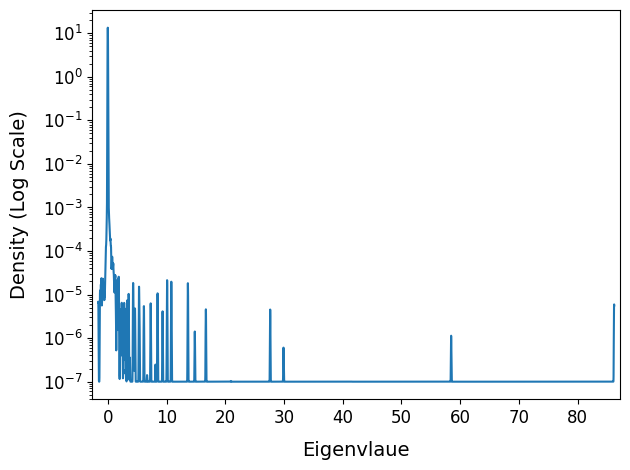

In [36]:
t0 = time.time()
density_eigen, density_weight = hessian_comp.density()
print("Obtained eigendensities and eigenweights in %.2f seconds"%(time.time()-t0))
get_esd_plot(density_eigen, density_weight)

In [37]:
len(density_eigen[0])

100

In [38]:
# Save the model
torch.save(model.state_dict(), 'model_cnn_cifar_10.pth')

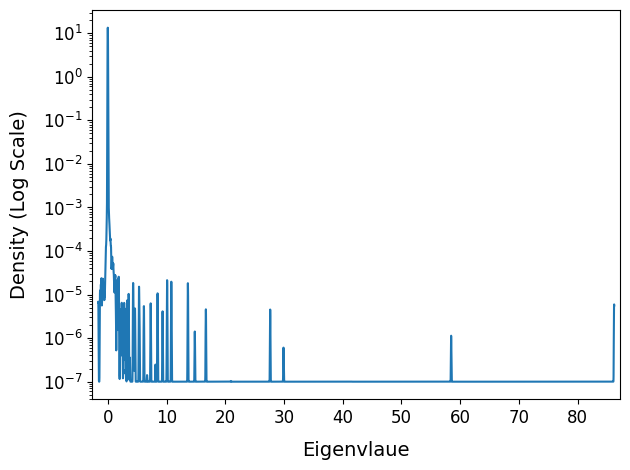

In [39]:
# Save the spectrum
# np.save('density_eigen_cnn_cifar_10.npy', density_eigen)
# np.save('density_weight_cnn_cifar_10.npy', density_weight)
# np.save('trace_cnn_cifar_10.npy', trace)
get_esd_plot(density_eigen, density_weight, save_path='cifar_10.png')
